## Topic Modeling with NMF and SVD
        Topic Modeling is a great way to get started with matrix factorizations. We'll start with term-document matrix:

        We can decompose this into one tall thin matrix times one wide short matrix.

        This representation does not take into account word order or sentence structure. It's an example of a bag of words approach.

#### Motiation 

        Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

        Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics.

### In this week's lecture,
        We'll take a dataset of documents in several different categories, and find topics for them. Knowing the actual categories help us evaluate if the topics we find make sense.


        We'll try this with : Singular Value Decomposition and Non-Negative Matrix Factorization

In [3]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt  

In [4]:
%matplotlib inline
np.set_printoptions(suppress=True)

### Set Up Data
        Scikit Learn comes with a number of built in datasets, as well as loading utilities to load several standard external datasets.  

        Newsgroups are discussion groups on USenet, which were popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.

In [5]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

        Look at some of the data

In [6]:
print("\n".join(newsgroups_train.data[:4]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

        In what categories the data belong to?
        

In [7]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:4]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space', 'alt.atheism'],
      dtype='<U18')

        We assign target index to each of them

In [8]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1], dtype=int64)

In [9]:
num_topics, num_top_words = 6, 8

        Scikit Learn has a method that will extract all the words count for us

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [11]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [12]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [13]:
vocab = np.array(vectorizer.get_feature_names_out())

In [14]:
vocab[7000:7050]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count', 'countdown', 'counted',
       'counter', 'counter_clockwise', 'counterargument',
       'counterclockwise', 'countered', 'counterexamples',
       'counterfactual', 'counterpart', 'counterproductive', 'counters',
       'counting', 'countless', 'countries', 'country', 'countryside',
       'counts', 'county', 'coup', 'couple', 'coupled', 'couples',
       'courage', 'courageous', 'courant', 'cournoyer', 'course',
       'courses', 'court'], dtype=object)

## Singular Value Decomposition

    We would expect that the words that appear most frequently in one topic would appear less frequently in the other. Therefore the topics should be orthogonal

    The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows

        SVD is an exact decompostion, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data sciences

In [15]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

Wall time: 1min 33s


In [16]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


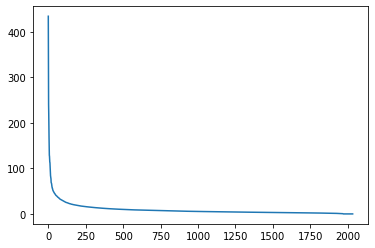

In [17]:
# plot for the singular values
plt.plot(s);

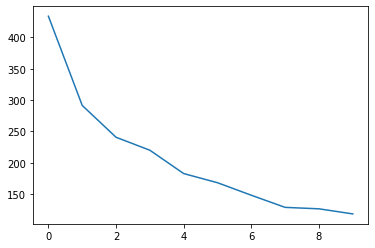

In [18]:
plt.plot(s[:10])


In [19]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [20]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

        We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an unsupervised algorithm - which is to say, we never actually told the algorithm how our documents are grouped.

### Non-negative Matrix Factorization (NMF)

#### Idea
        Rather than constraining our factors to be orthogonal, another idea would be to constrain them to be non-negative. NMF is a factorization of a non-negative data set V:
            V = WH

        into non-negative matrices W, H. Often positive factors will be more reasily iterpretable.
        
        NMF is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. NMF is NP-hard and non-unique. There are number of variations on it, created by adding different constraints.



### NMF from Sklearn

In [21]:
m,n = vectors.shape
d = 5 # number of topics

In [ ]:
clf = decomposition.NMF(n_components  = d, random_state = 135)
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [23]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

        Topic Frequency-Inverse Document Frequency is a way to normalize term counts by taking into account how often they apear in a document, how long the document is and how common/rare they are in a document.

        TF = (# occurences of terms t in document) / (# of words in documents)

        IDF = log(# of documents / # documents with term t in it)

In [24]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data)

In [25]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

c:\Users\Monit Sharma\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [26]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

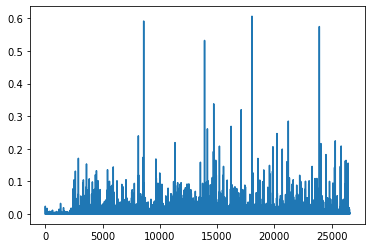

In [27]:
plt.plot(clf.components_[0])

In [28]:
clf.reconstruction_err_

43.7129260580871

### NMF in summary

    Benefits : fast and easy to use

    Downside : took years of research and expertise to create

    Notes:
        1. For NMF, matrix needs to be at least as tall as it is wide, or we get error with fit_transform
        2. Can use df_min in CountVectorizer to only look ar words that were in at least k of the split texts

### NMF from scratch in  NumPy ,  using Stochastic Gradient Descent

        The key idea of standard gradient descent 
        1. Randomly choose some weights to start
        2. Loop:
           1. Use Weights to calculate a prediciton
           2. Calculate the derivative of the loss
           3. Update the weights
        3. Repeat step 2 lots of times, eventually end up with some descent weights.
        
        We want to decrease our loss and the derivative tells us the direction of steepest descent.

### Stochastic Gradient Descent (SGD)

    It is an incredibly useful optimization method ( it is also the heart of deep learning, since used for backpropoagation)

    We evaluate the loss using all our data for standard gradient descent, which is slow.

    In stochastic gradient descent , we evaluate our loss function on just a sample of our data. We would get differet loss values on different samples of the data. It turns out this is still effective way to optimize.


#### Applying SGD to NMF
        Goal: Decompose V(m * n) into 
                V = WH
            where W and H >=0 , and we've minimized the Frobenius norm of V- WH

        Approach: We will pick random positive W & H , and then use SGD to optimize.

In [29]:
lam = 1e3
lr = 1e-2 
m, n = vectors_tfidf.shape

In [30]:
W1= clf.fit_transform(vectors)
H1 = clf.components_

c:\Users\Monit Sharma\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
c:\Users\Monit Sharma\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [31]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [32]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [33]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

In [34]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [35]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [36]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [37]:
report(vectors_tfidf, W, H)

44.42710988660707 1.4206941402729504e-06 6.220086649529336e-08 0 0


In [38]:
upd(vectors_tfidf,W,H,lr)

In [39]:
report(vectors_tfidf, W, H)

44.419184642449935 -0.0007765716529699559 -7.190500098920772e-05 134 284


In [40]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.41318263157269 -0.0008430536728499327 -7.167740576098002e-05 130 261
44.375136145889066 -0.0003328731899605962 -4.81782057093232e-05 52 522
44.34628347718999 -0.0002643278292372564 -6.728869170547078e-05 41 958
44.31425263334867 -0.00014943471301808218 -9.658154475246471e-05 26 1518
44.279008899552316 -0.0001003564775838509 -0.00012961678356928944 25 2244


In [41]:
show_topics(H)

['god space like people don just think know',
 'space people don just think know god like',
 'space god don people think just know like',
 'god don people space just like think know',
 'god space don people just know like think']

        This is painfully slow to train! Lots  o fparameter fiddling and still slow to train

### PyTorch
 
        It is a Python framework for tensors and dynamic neural networks with GPU accelaration. Similar to NumPy , only with increases parallelization of using GPU

        If you are not using a GpPU , you will need to remove the .cuda() from this method below                                .

In [43]:
import torch
import torch as tc
from torch.autograd import Variable

In [44]:
def V(M): return Variable(M, requires_grad=True)

In [45]:
v=vectors_tfidf.todense()

In [46]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [47]:
mu = 1e-5

In [48]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(tc.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [49]:
t_W = tc.FloatTensor(m,d)
t_H = tc.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [50]:
d=6; lam=100; lr=0.05

In [51]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

tensor(44.3427) tensor(-0.0051) tensor(-0.0004) tensor(783) tensor(1398)
tensor(43.7378) tensor(-0.0065) tensor(-0.0100) tensor(1473) tensor(18494)
tensor(43.7144) tensor(-0.0064) tensor(-0.0042) tensor(1633) tensor(19758)
tensor(43.7058) tensor(-0.0044) tensor(-0.0055) tensor(1688) tensor(19458)
tensor(43.7021) tensor(-0.0055) tensor(-0.0052) tensor(1856) tensor(19207)
tensor(43.7011) tensor(-0.0041) tensor(-0.0040) tensor(2211) tensor(20863)
tensor(43.7006) tensor(-0.0034) tensor(-0.0062) tensor(2395) tensor(21466)
tensor(43.7003) tensor(-0.0041) tensor(-0.0039) tensor(2256) tensor(22396)
tensor(43.7001) tensor(-0.0043) tensor(-0.0055) tensor(2204) tensor(22454)
tensor(43.6999) tensor(-0.0039) tensor(-0.0050) tensor(2513) tensor(28230)


In [52]:
show_topics(t_H.cpu().numpy())

['people don think just objective like say morality',
 'god jesus bible believe atheism christian belief does',
 'graphics comp software group 3d just aspects amiga',
 'thanks files file image program windows format know',
 'space nasa launch shuttle orbit moon lunar earth']

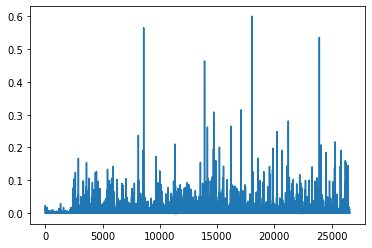

In [53]:
plt.plot(t_H.cpu().numpy()[0])

In [54]:
t_W.mm(t_H).max()

tensor(0.3829)

In [55]:
t_vectors.max()

tensor(1.)

### PyTorch Autograd Introduction

In [56]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [57]:
print(x.data)

tensor([[1., 1.],
        [1., 1.]])


In [58]:
print(x.grad)

None


In [59]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [60]:
z = y * y * 3
out = z.sum()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(108., grad_fn=<SumBackward0>)


In [61]:
out.backward()
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


#### Using Autograd for NMF

In [62]:
lam=1e6

In [63]:
pW = Variable(tc.FloatTensor(m,d), requires_grad=True)
pH = Variable(tc.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [64]:
def report():
    W,H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).data[0], W.min(), H.min(), (W<0).sum(), (H<0).sum())

def penalty(A):
    return torch.pow((A<0).type(tc.FloatTensor)*torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M-pW.mm(pH)).norm(2) + penalize()*lam

In [65]:
M = Variable(t_vectors)

In [67]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
#report()

In [ ]:
h = pH.data.cpu().numpy()
show_topics(h)

In [ ]:
plt.plot(h[0]);

### Comparing Appraoches
#### Scikit-Learns's NMF

    1.  Fast
    2.  No Parameter tuning
    3.  Relies on decaded of academic research
   
#### Using PyTorch and SGD
    1. Took an hour to implement, didn't have to be NMF experts
    2. Parameters were dfiddy
    3. Not as fast
